## Drug Classification

The University Hospital has perceived a recent influx of patients that has led to increasingly hectic schedules for the healthcare staff. After observing the hospital's activity for a period of time, the doctors have noticed that many patients are coming in for similar health concerns and the vast majority of the prescribed medications are from a selection of 5 drugs. As a data scientist working for the hospital, your task is to construct a **K-nearest neighbors (KNN) classifier** based on the **drug200.csv** file (included in the Data directory). The classifier should predict which drug should be prescribed given the patient data.

If the classifier works well, patient hospital visits can be more streamlined with a physician at the end for checking to ensure the prescribed medication is correct. The hospital hopes that this will alleviate some pressure on the staff while maintaining the hospital's ability to treat patients.

**Note**: The dataset used was extracted from [Kaggle](https://www.kaggle.com/prathamtripathi/drug-classification). Feel free to have a look at the available notebooks to find some hints that may help you to accomplish this task. Additionally, we provide you with a short explanation about KNN below.

### K-nearest neighbors - a lazy learning algorithm

The KNN algorithm itself is fairly straightforward and can be summarized by the following steps:

1. Choose the number of k and a distance metric.
2. Find the k-nearest neighbors of the data record that we want to classify.
3. Assign the class label by majority vote.

The following figure illustrates how a new data point, indicated by ?, is assigned the triangle class label based on majority voting among its five nearest neighbors:

<div style='align: left; text-align:center;'><br/>
    <img src='img/knnprinc.png' alt='KNN principle' style="height:250px;"/>
    <span style='display:block;'>KNN Principle. Image Source: <a href="https://subscription.packtpub.com/book/data/9781789955750/2/ch02lvl1sec09/artificial-neurons-a-brief-glimpse-into-the-early-history-of-machine-learning" target="_blank">The Neural Network Blog</a>.</span>
    <br/>
</div>

Based on the chosen distance metric, the KNN algorithm finds the k examples in the training dataset that are closest (most similar) to the point that we want to classify. The class label of the data point is then determined by a majority vote among its k nearest neighbors.

The main advantage of such a "memory-based" approach is that the classifier immediately adapts as we collect new training data. However, the downside is that the computational complexity for classifying new examples grows linearly with the number of examples in the training dataset in the worst-case scenario—unless the dataset has very few dimensions (features) and the algorithm has been implemented using efficient data structures. Furthermore, we can't discard training examples since no training step is involved. Thus, storage space can become a challenge if we are working with large datasets.

The right choice of k is crucial to finding a good balance between overfitting and underfitting. We also have to make sure that we choose a distance metric that is appropriate for the features in the dataset. Often, a simple Euclidean distance measure is used for real-value examples, for example, the flowers in the Iris dataset, which have features measured in centimeters. However, if we are using a Euclidean distance measure, it is also important to standardize the data so that each feature contributes equally to the distance.

**Solution sketch**

1. Load the dataset with Pandas.
2. Use `from sklearn.preprocessing import OrdinalEncoder` to transform ordinal categorical features into a numerical representation. Additionally, handle non-ordinal categorical features with one-hot encoding.
3. Use `from sklearn.preprocessing import LabelEncoder` to transform the class label into a numerical representation.
4. Split the preprocessed data into train/test. Since the data is imbalanced, you should use a [stratified shuffle split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
5. Select the best value of k in between 1 and 20 (inclusive).
6. Use `from sklearn.metrics import plot_confusion_matrix` to plot the confusion matrix for the best KNN model found.

**Sample solution**

In [109]:
%matplotlib inline

import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('seaborn') # Configure plt to use seaborn plot style
plt.rcParams["figure.figsize"] = (12, 5) # Set the figure size for plotting Globally
sns.set(font_scale=0.8)  # Set the font size for all plots

### Load the data 

We start by loading the data and checking data types for each column.

In [110]:
# Load the dataset
drug_data = pd.read_csv(os.path.join('Data', 'drug200.csv'))
drug_data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [111]:
# Check data types
drug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


### Exploratory Data Analysis

Let's check how the features affect drug type prescriptions. Here, interesting questions to ask the data are: 

* Are there certain threshold values that lead to drug X prescribed over drug Y? 
* What are the combinations of feature (e.g., "Age" and "Na_to_K") values, if any, that lead to drug Z to be prescribed over drug W? 

These are all questions we can investigate by plotting each feature against "Drug".

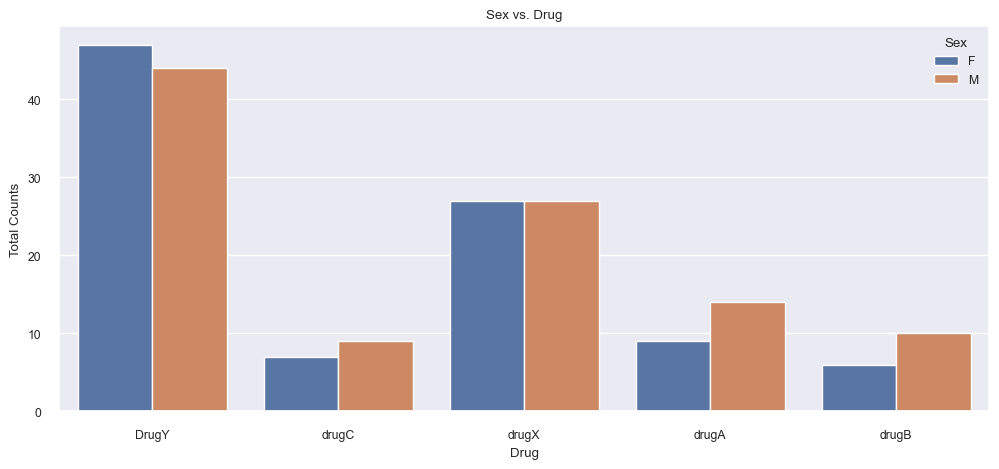

In [112]:
# Checking the relationship between Drug and Sex 
sns.countplot(x="Drug", hue="Sex", data=drug_data)

plt.title("Sex vs. Drug")
plt.xlabel("Drug")
plt.ylabel("Total Counts")
plt.show()

<AxesSubplot:>

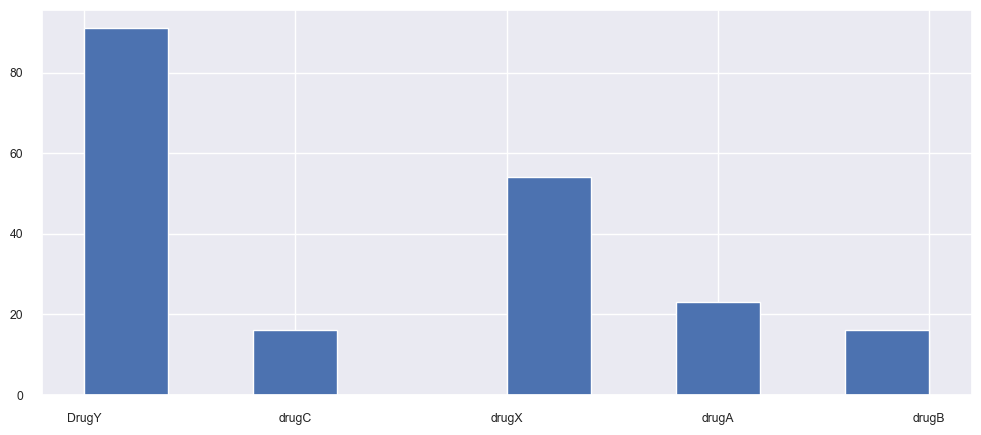

In [113]:
drug_data['Drug'].hist() # good for histogram on 1 column

**Findings**: There doesn't seem to be a drug that is prescribed exclusively for each sex. In fact, the distributions look quite similar, suggesting that "Sex" is not very important in determining the drug type.

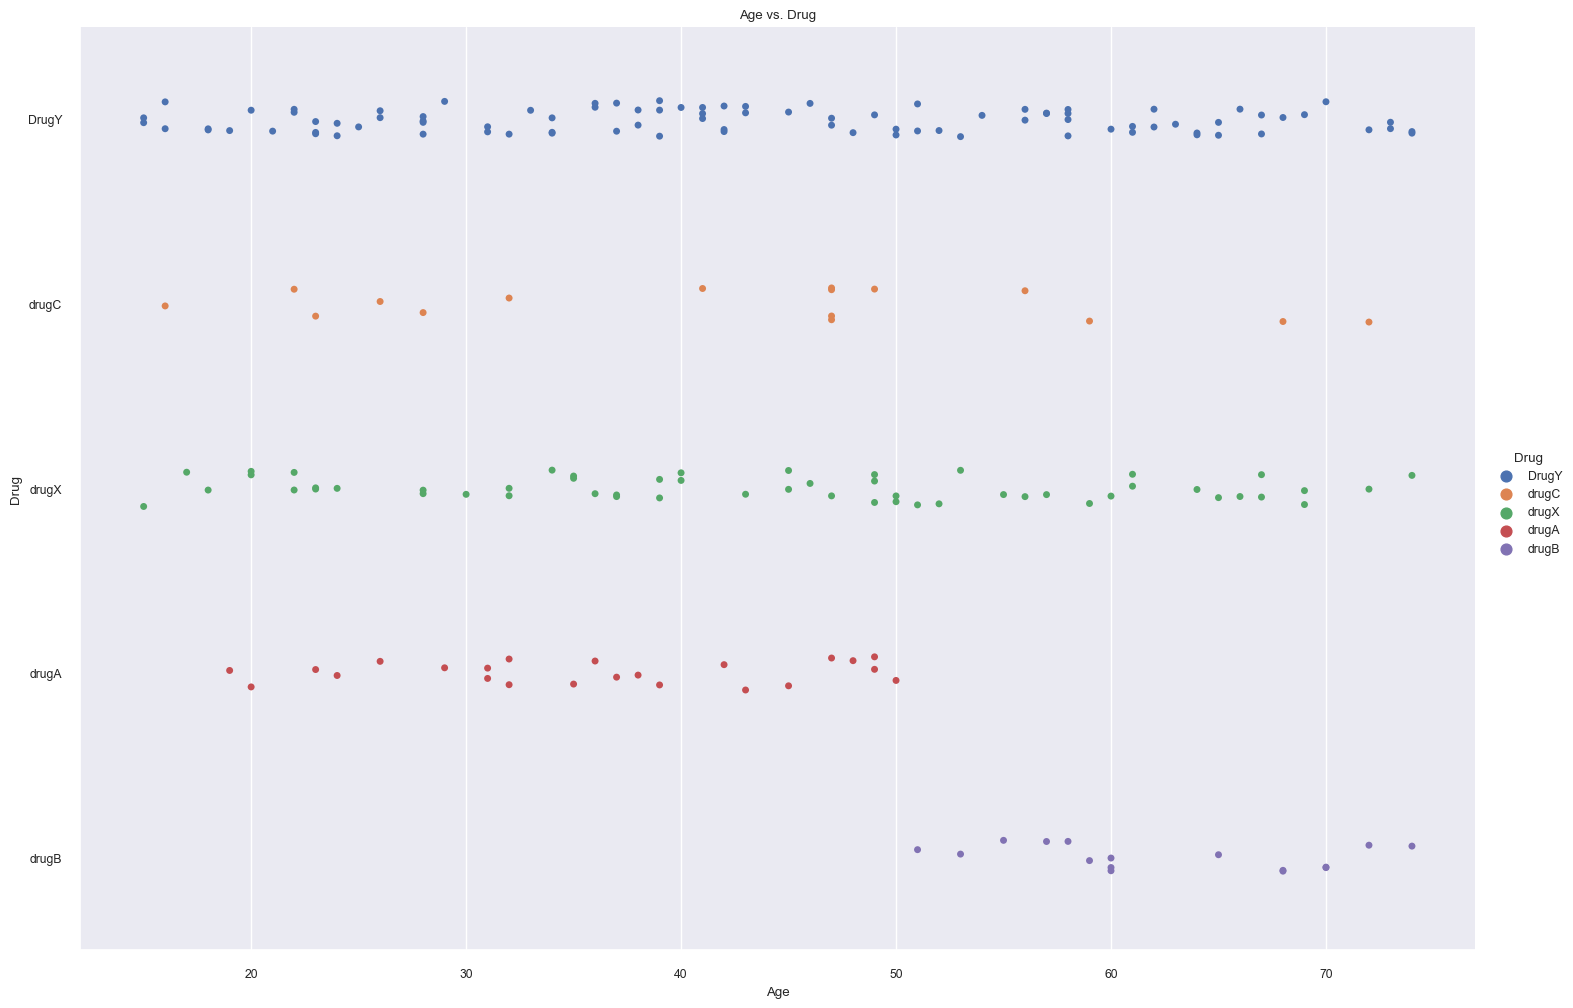

In [114]:
# Checking the relationship between Drug and Age
sns.catplot(x="Age", y="Drug", hue = "Drug",data=drug_data, height=10, aspect=15/10)
#sns.scatterplot(x="Age", y="Drug", hue = "Drug",data=drug_data)  # not the same as catplot
plt.title("Age vs. Drug")
plt.show()

**Findings**: Drugs Y, C, and X seem to be prescribed for all ages in the dataset while A and B have clear age cut-offs. **It looks like drug A is precribed for ages ~ [20-50] while B is prescribed for ages ~ [51-75].** Our classifier should take this into account.

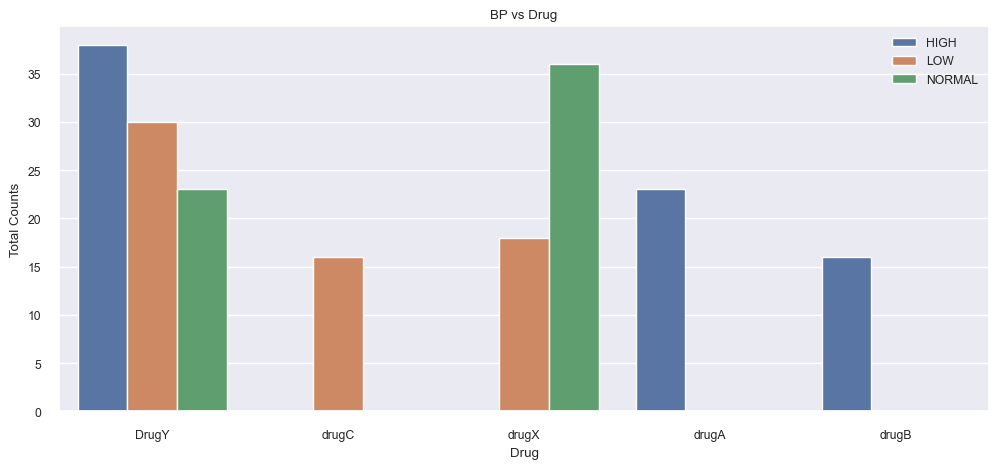

In [115]:
# Checking the relationship between Drug and BP
sns.countplot(x="Drug", hue="BP", data=drug_data)
plt.title("BP vs Drug")
plt.xlabel("Drug")
plt.ylabel("Total Counts")
plt.legend(loc='upper right') # Position legend
plt.show()

**Findings**: BP levels seem to affect which drug type is prescribed. 

* "High" BP patients were prescribed drugs B, A, and Y. 
* "Low" BP patients were prescribed drugs X, C, and Y. 
* "Normal" BP patients were prescribed drugs X and Y.

Notice that some drugs were prescribed to multiple BP levels (e.g., drug Y: "High", "Low", and "Normal"). In contrast, **some drugs were prescribed exclusively to a specific BP level (e.g., drug C: "Low").** Hence, BP seems to be informative but not deterministic in deciding which drug type to prescribe.

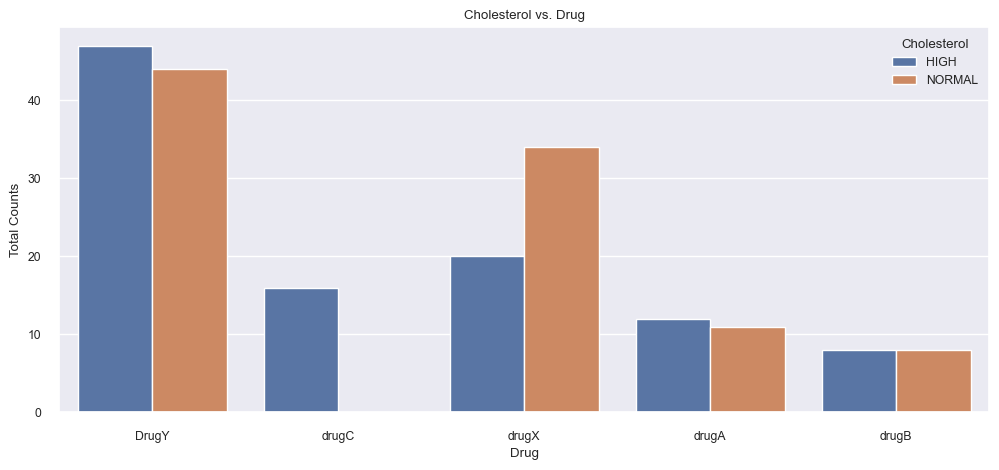

In [116]:
# Checking the relationship between Drug and Cholesterol
sns.countplot(x="Drug", hue="Cholesterol", data=drug_data)
plt.title("Cholesterol vs. Drug")
plt.xlabel("Drug")
plt.ylabel("Total Counts")
plt.show()

**Findings**: It looks like most drugs are prescribed to patients with both cholesterol levels. The only exception is **drug C which is exclusively prescribed to patients with "High" cholesterol.**

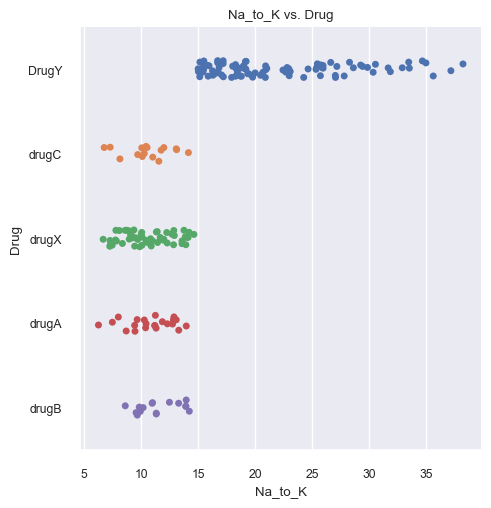

In [117]:
# Checking the relationship between Drug and Na_to_K
sns.catplot(x="Na_to_K", y="Drug", data=drug_data)
#sns.scatterplot(x="Na_to_K", y="Drug", data=drug_data)
plt.title("Na_to_K vs. Drug")
plt.show()

**Findings**: It looks like drugs C, X, A, and B are prescribed for patients with "Na_to_K" values below 15 while **drug Y is exclusively precribed for values above.**

**Overall insight (for feature selection)**: We can use our findings to select features that can discriminate different drug prescriptions. For instance, we notice that drug Y was prescribed for all values (e.g., "all ages" and "High", "Low", and "Normal" BP). However, in the "Na_to_K" plot above, only patients with values greater than 15 are prescribed drug Y. 

Therefore, "Na_to_K" measurements seem to be crucial in deciding whether to prescribe drug Y or not. 

On the other hand, feature "Sex" has no apparent impact on the drug prescrition and can be removed from our feature set. Our classifier should take that into consideration.

### Data preparation

Some features contain categorical values (e.g., "BP" with values "High", "Low", and "Normal") and must be transformed into a numerical representation.

We start by transforming ordinal features:

In [118]:
ordinal_enc = OrdinalEncoder()

ordinal_features = drug_data[["BP", "Cholesterol"]]
encoded_ordinal = ordinal_enc.fit_transform(ordinal_features)

Now, let's transform class labels (i.e., prescribed drugs):

In [119]:
label_enc = LabelEncoder()
# Reshape is needed for sklearn classifiers
encoded_labels = label_enc.fit_transform(drug_data.Drug).reshape(-1,1)

We can create a new dataset that contains all encoded features and lables:

In [120]:
# New DataFrame with encoded features
ordinal_df = pd.DataFrame(encoded_ordinal, columns=["BP", "Cholesterol"])

# New DataFrame with encoded labels
labels_df = pd.DataFrame(encoded_labels, columns=["Drug"])

# Make a copy of the original DataFrame without the categorical features.
# Note that we remove the "Sex" feature, because it seems to be uninformative.
numeric_df = drug_data.drop(["BP", "Cholesterol", "Drug", "Sex"], axis=1)   # Keep Age and	Na_to_K

# Concat all features with lables
prep_dataset = pd.concat([numeric_df, ordinal_df, labels_df], axis=1)

prep_dataset.head()

,Age,Na_to_K,BP,Cholesterol,Drug
0,23,25.355,0.0,0.0,0
1,47,13.093,1.0,0.0,3
2,47,10.114,1.0,0.0,3
3,28,7.798,2.0,0.0,4
4,61,18.043,1.0,0.0,0


Let's separate features from labels:

In [121]:
X = prep_dataset[prep_dataset.columns[:-1]]
y = prep_dataset.Drug

Let's scale the features to avoid giving more importance to features with a larger scale:

In [122]:
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)

In [123]:
X_std

array([[-1.29159102,  1.28652212, -1.11016894, -0.97043679],
       [ 0.16269866, -0.4151454 ,  0.10979693, -0.97043679],
       [ 0.16269866, -0.82855818,  0.10979693, -0.97043679],
       [-0.988614  , -1.14996267,  1.32976279, -0.97043679],
       [ 1.0110343 ,  0.27179427,  0.10979693, -0.97043679],
       [-1.35218642, -1.03769314,  1.32976279, -0.97043679],
       [ 0.28388946,  0.02643885,  1.32976279, -0.97043679],
       [-0.20087376, -0.70046821,  0.10979693, -0.97043679],
       [ 0.9504389 , -0.12676951,  1.32976279, -0.97043679],
       [-0.07968296,  0.45567206,  0.10979693,  1.03046381],
       [ 0.16269866, -0.59916196,  0.10979693, -0.97043679],
       [-0.62504158,  0.43221897, -1.11016894,  1.03046381],
       [-0.07968296, -0.09832049,  0.10979693, -0.97043679],
       [ 1.79877454,  0.674105  ,  0.10979693, -0.97043679],
       [ 0.34448487, -0.46926791,  1.32976279, -0.97043679],
       [-1.71575884, -0.0788919 , -1.11016894,  1.03046381],
       [ 1.49579753, -0.

We generate train/test sets using a stratified sampling to account label imbalance:

In [124]:
# Random_state=42 is used for reproducibility.
# It guarantees that the split will be the same every time.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Data Modeling

With the dataset ready for modeling, we can start defining and training our KNN estimator/model:

In [125]:
estimator = KNeighborsClassifier(n_neighbors=5)
estimator.fit(X_train, y_train)

KNeighborsClassifier()

**Evaluating training performance**

In [126]:
print(classification_report(y_train, estimator.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95        64
           1       0.55      0.69      0.61        16
           2       0.53      0.73      0.62        11
           3       0.50      0.36      0.42        11
           4       0.77      0.61      0.68        38

    accuracy                           0.77       140
   macro avg       0.66      0.67      0.65       140
weighted avg       0.78      0.77      0.77       140



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


**Evaluating test performance**

In [127]:
print(classification_report(y_test, estimator.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        27
           1       0.30      0.43      0.35         7
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00         5
           4       0.57      0.50      0.53        16

    accuracy                           0.62        60
   macro avg       0.41      0.41      0.40        60
weighted avg       0.59      0.62      0.60        60



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [128]:
from sklearn.metrics import accuracy_score # Accuracy metric

y_predicted = estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_predicted))

Accuracy: 0.6166666666666667


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


**Confusion Matrix**

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


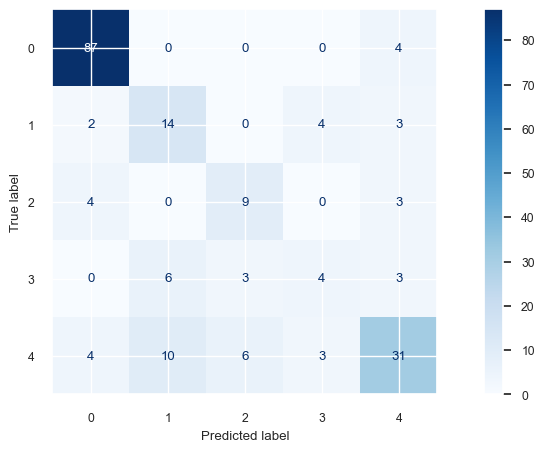

In [129]:
plot_confusion_matrix(estimator, X, y, cmap="Blues")
plt.show()

In [130]:
##### Same process using Scaled X variables

# Random_state=42 is used for reproducibility.
# It guarantees that the split will be the same every time.
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=42, stratify=y)

estimator = KNeighborsClassifier(n_neighbors=5)
estimator.fit(X_train, y_train)



KNeighborsClassifier()

In [131]:
estimator = KNeighborsClassifier(n_neighbors=5)
estimator.fit(X_train, y_train)

print(classification_report(y_train, estimator.predict(X_train)))   # training performance
print(classification_report(y_test, estimator.predict(X_test)))     # testing performance

              precision    recall  f1-score   support

           0       0.98      0.94      0.96        64
           1       0.88      0.88      0.88        16
           2       0.83      0.91      0.87        11
           3       0.92      1.00      0.96        11
           4       0.97      1.00      0.99        38

    accuracy                           0.95       140
   macro avg       0.92      0.94      0.93       140
weighted avg       0.95      0.95      0.95       140

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        27
           1       1.00      0.71      0.83         7
           2       0.50      0.40      0.44         5
           3       1.00      1.00      1.00         5
           4       0.79      0.94      0.86        16

    accuracy                           0.83        60
   macro avg       0.83      0.78      0.80        60
weighted avg       0.84      0.83      0.83        60



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

In [132]:
from sklearn.metrics import accuracy_score # Accuracy metric

y_predicted = estimator.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_predicted))

Accuracy: 0.8333333333333334


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


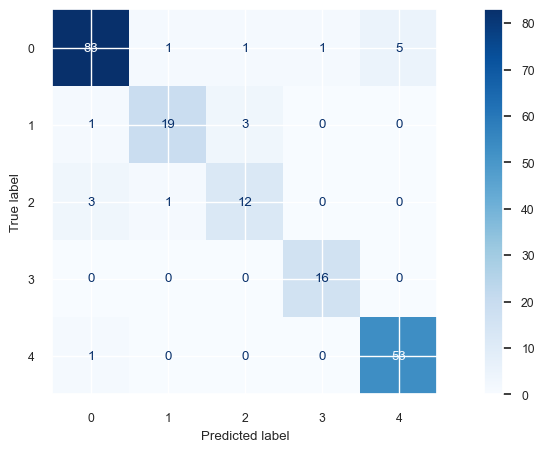

In [133]:
plot_confusion_matrix(estimator, X_std, y, cmap="Blues")
plt.show()

**Model Selection**

Let's use a StratifiedKFold cross-validation procedure to select the best number of k within the range \[1, 20\]:

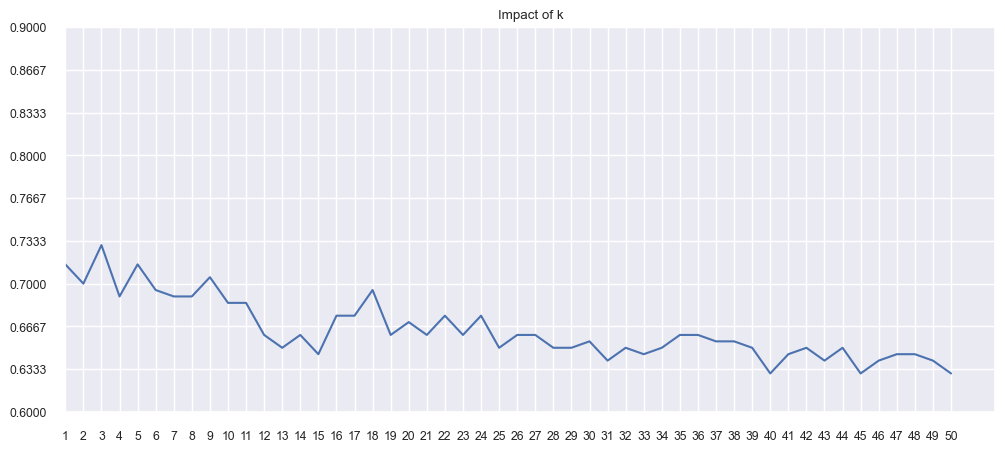

In [134]:
values_of_k = []
accuracy = []

for k in range(1, 51):
    # Create estimator
    estimator = KNeighborsClassifier(n_neighbors=k)
    # Define the evaluation procedure
    cv = StratifiedKFold(n_splits=5)
    # Compute the cross-validation test accuracy score
    scores = cross_val_score(estimator, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # Compute mean accuracy
    accuracy.append(np.mean(scores))
    # Add the current value of k to create a plot.
    values_of_k.append(k)

plt.title('Impact of k') # Define the plot title
plt.plot(values_of_k, accuracy) # Plot the accuracy score produced by each value of k
plt.xticks([i for i in range(1, 51)])
plt.yticks(np.linspace(0.6, 0.9, 10))
plt.xlim(1) # Set the x-axis at 1. The dafault value is 0.
plt.show()

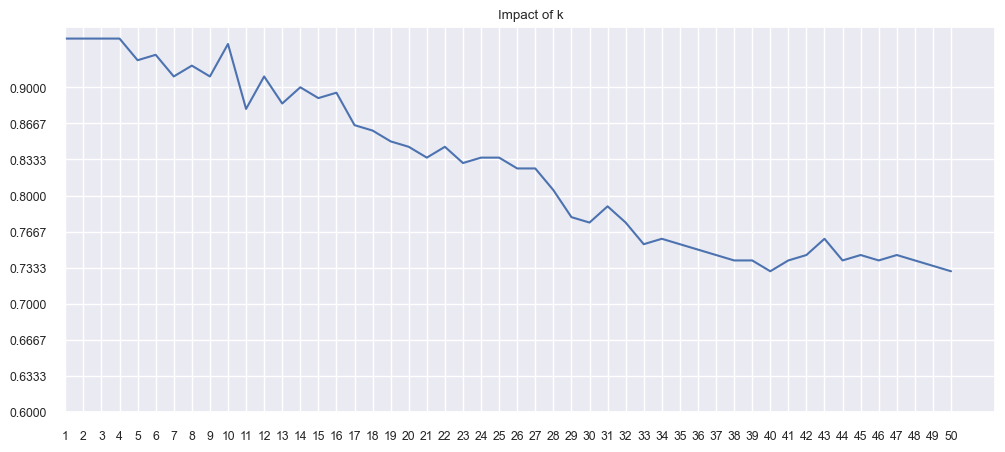

In [135]:
values_of_k = []
accuracy = []

for k in range(1, 51):
    # Create estimator
    estimator = KNeighborsClassifier(n_neighbors=k)
    # Define the evaluation procedure
    cv = StratifiedKFold(n_splits=5)
    # Compute the cross-validation test accuracy score
    scores = cross_val_score(estimator, X_std, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # Compute mean accuracy
    accuracy.append(np.mean(scores))
    # Add the current value of k to create a plot.
    values_of_k.append(k)

plt.title('Impact of k') # Define the plot title
plt.plot(values_of_k, accuracy) # Plot the accuracy score produced by each value of k
plt.xticks([i for i in range(1, 51)])
plt.yticks(np.linspace(0.6, 0.9, 10))
plt.xlim(1) # Set the x-axis at 1. The dafault value is 0.
plt.show()

#### End of Case Study